In [2]:
import pandas as pd
import numpy as np

import torch
from sklearn.model_selection import train_test_split

import pyro
import pyro.distributions as dist
import pyro.infer
from pyro.infer import MCMC, NUTS

In [26]:
df_k55 = pd.read_csv(
    'doc_topics_K55.csv'
)
df_k60 = pd.read_csv(
    'doc_topics_K60.csv'
)
df_k55.head()
#df_k60.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_45,topic_46,topic_47,topic_48,topic_49,topic_50,topic_51,topic_52,topic_53,topic_54
0,0.349177,0.000026,0.422450,0.000230,0.000213,0.073040,0.000137,0.000019,0.001023,0.000069,...,0.000081,0.000138,0.000019,0.000137,0.000082,0.000138,0.000019,0.000132,0.000080,0.000138
1,0.260056,0.000414,0.000029,0.289874,0.000136,0.000088,0.000029,0.000046,0.000167,0.000088,...,0.000090,0.000029,0.000047,0.000407,0.000090,0.000029,0.000047,0.000408,0.000090,0.000029
2,0.000018,0.615313,0.000016,0.000036,0.000177,0.242171,0.000015,0.000036,0.000191,0.135602,...,0.000169,0.000015,0.000036,0.000178,0.000115,0.000015,0.000036,0.000178,0.000113,0.000015
3,0.008549,0.000010,0.000003,0.177424,0.000101,0.000024,0.000003,0.000007,0.000103,0.000024,...,0.000024,0.000003,0.000007,0.000142,0.000024,0.000003,0.000007,0.000142,0.000024,0.000003
4,0.000020,0.000045,0.000013,0.000013,0.171834,0.000288,0.000008,0.000013,0.000302,0.000067,...,0.000074,0.000008,0.000015,0.000915,0.000075,0.000008,0.000014,0.000911,0.000074,0.000008


In [27]:
df_sms = pd.read_csv(
    "SMSSpamCollection", sep="\t", header=None, names=["label", "message"]
)
#df_sms.head()
df_sms["label"] = df_sms["label"].map({"ham": 0, "spam": 1})
df_sms.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [28]:
df_k55["label"] = df_sms["label"]
df_k55.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_46,topic_47,topic_48,topic_49,topic_50,topic_51,topic_52,topic_53,topic_54,label
0,0.349177,0.000026,0.422450,0.000230,0.000213,0.073040,0.000137,0.000019,0.001023,0.000069,...,0.000138,0.000019,0.000137,0.000082,0.000138,0.000019,0.000132,0.000080,0.000138,0
1,0.260056,0.000414,0.000029,0.289874,0.000136,0.000088,0.000029,0.000046,0.000167,0.000088,...,0.000029,0.000047,0.000407,0.000090,0.000029,0.000047,0.000408,0.000090,0.000029,0
2,0.000018,0.615313,0.000016,0.000036,0.000177,0.242171,0.000015,0.000036,0.000191,0.135602,...,0.000015,0.000036,0.000178,0.000115,0.000015,0.000036,0.000178,0.000113,0.000015,1
3,0.008549,0.000010,0.000003,0.177424,0.000101,0.000024,0.000003,0.000007,0.000103,0.000024,...,0.000003,0.000007,0.000142,0.000024,0.000003,0.000007,0.000142,0.000024,0.000003,0
4,0.000020,0.000045,0.000013,0.000013,0.171834,0.000288,0.000008,0.000013,0.000302,0.000067,...,0.000008,0.000015,0.000915,0.000075,0.000008,0.000014,0.000911,0.000074,0.000008,0


In [29]:
# train and test split
X = df_k55.drop(columns=["label"]).values.astype("float32")
y = df_k55["label"].values.astype("float32")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# convert to PyTorch tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [30]:
def model(X, y=None):
    num_features = X.shape[1]

    # Priors for weights and bias
    beta = pyro.sample("beta", dist.Normal(torch.zeros(num_features), torch.ones(num_features)))
    bias = pyro.sample("bias", dist.Normal(0., 1.))

    with pyro.plate("data", X.shape[0]):
        logits = (X @ beta) + bias
        pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

In [31]:
# MCMC inference
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=200, num_chains=1)
mcmc.run(X_train, y_train)

Sample: 100%|██████████| 2200/2200 [01:03, 34.80it/s, step size=3.60e-01, acc. prob=0.910]


In [32]:
# prediction using posterior mean
samples = mcmc.get_samples()
beta_hat = samples["beta"].mean(0)
bias_hat = samples["bias"].mean(0)

# Predict on test set
logits = (X_test @ beta_hat) + bias_hat
y_pred = torch.sigmoid(logits) > 0.5

# Accuracy
accuracy = (y_pred.int() == y_test).float().mean()
print("Test Accuracy:", accuracy.item())

Test Accuracy: 0.926457405090332


In [33]:
print(mcmc.diagnostics())


{'beta': OrderedDict([('n_eff', tensor([2934.7092, 1430.8804, 2822.8889, 4210.8506, 3318.2952, 2515.4717,
        3185.7637, 1982.7726, 4147.3848, 2300.2471, 4027.8564, 2868.5396,
        2778.0872, 5117.0029, 4659.6333, 3665.9197, 4204.5186, 2322.3413,
        3901.9795, 3740.9280, 2340.7908, 2802.1943, 3518.2178, 2867.4001,
        4820.7300, 3999.6289, 6412.1533, 4989.5044, 2450.9888, 2845.3772,
        3530.9939, 5272.4297, 4766.0117, 3075.8269, 4599.2671, 6195.8120,
        5205.8262, 4015.2668, 6669.1582, 4046.9390, 4285.4312, 3570.0513,
        4087.5688, 4980.4902, 1626.1288, 3855.7979, 2917.7710, 5562.7944,
        4510.7139, 4217.5063, 5298.2705, 5210.3096, 5603.1499, 2514.2532,
        6388.7632])), ('r_hat', tensor([1.0001, 0.9999, 0.9995, 0.9998, 0.9997, 0.9995, 0.9996, 0.9995, 1.0004,
        0.9996, 1.0002, 0.9997, 0.9996, 0.9995, 0.9995, 0.9995, 0.9996, 0.9995,
        0.9996, 1.0009, 0.9996, 0.9995, 0.9998, 0.9995, 0.9995, 0.9995, 0.9995,
        0.9995, 0.9995, 1.0000

# try with the bow matrix 

In [3]:
df_k55 = pd.read_csv(
    'doc_topics_K55.csv'
)

df_sms = pd.read_csv(
    "SMSSpamCollection", sep="\t", header=None, names=["label", "message"]
)
#df_sms.head()
df_sms["label"] = df_sms["label"].map({"ham": 0, "spam": 1})


df_k55["label"] = df_sms["label"]

In [4]:
bow_array = np.load("BoW_X_Array.npz")["arr_0"]
print(bow_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
# Drop the label column from df_k55 to get the topic features
X_topics = df_k55.drop("label", axis=1).values.astype("float32")

# Check shapes to be sure
print("Topics shape:", X_topics.shape)
print("BoW shape:", bow_array.shape)

# Horizontally concatenate the two matrices
X = np.hstack([X_topics, bow_array])
print('total shape: ', X.shape)

# Extract the labels
y = df_k55["label"].values.astype("float32")
print('labels shape',y.shape)

Topics shape: (5572, 55)
BoW shape: (5572, 7099)
total shape:  (5572, 7154)
labels shape (5572,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# convert to PyTorch tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [7]:
def model(X, y=None):
    num_features = X.shape[1]

    # Priors for weights and bias
    beta = pyro.sample("beta", dist.Normal(torch.zeros(num_features), torch.ones(num_features)))
    bias = pyro.sample("bias", dist.Normal(0., 1.))

    with pyro.plate("data", X.shape[0]):
        logits = (X @ beta) + bias
        pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

In [8]:
# MCMC inference
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc.run(X_train, y_train)

Sample: 100%|██████████| 1100/1100 [05:26,  3.37it/s, step size=1.58e-01, acc. prob=0.836]


In [9]:
# prediction using posterior mean
samples = mcmc.get_samples()
beta_hat = samples["beta"].mean(0)
bias_hat = samples["bias"].mean(0)

# Predict on test set
logits = (X_test @ beta_hat) + bias_hat
y_pred = torch.sigmoid(logits) > 0.5

# Accuracy
accuracy = (y_pred.int() == y_test).float().mean()
print("Test Accuracy:", accuracy.item())

Test Accuracy: 0.9856502413749695


In [10]:
print(mcmc.diagnostics())

{'beta': OrderedDict([('n_eff', tensor([1588.4603, 1364.0521, 1244.2787,  ..., 2388.4956, 1941.5050,
        2733.9429])), ('r_hat', tensor([0.9991, 1.0009, 0.9998,  ..., 1.0008, 0.9990, 0.9992]))]), 'bias': OrderedDict([('n_eff', tensor(998.0464)), ('r_hat', tensor(1.0022))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 1.0}}


# explanability 

In [11]:
# Suppose:
# - X_topics.shape[1] = 55
# - bow_array.shape[1] = 500 (or whatever number of BoW features)

topic_weights = beta_hat[:55].numpy()
bow_weights = beta_hat[55:].numpy()


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer

# Adjust max_features to match what you used earlier (e.g. 500)
vectorizer = CountVectorizer(max_features=bow_array.shape[1])

# Fit it to the raw messages
vectorizer.fit(df_sms["message"])  # assumes your original messages are in df_sms["message"]


bow_feature_names = vectorizer.get_feature_names_out()


In [15]:
import pandas as pd

bow_df = pd.DataFrame({
    "term": bow_feature_names,
    "weight": bow_weights
}).sort_values(by="weight", ascending=False)

print("Top BoW terms indicating SPAM:")
print(bow_df.head(10))

print("\nTop BoW terms indicating HAM:")
print(bow_df.tail(10))


Top BoW terms indicating SPAM:
             term    weight
6390      typical  3.117990
1070          arm  2.346373
5781  subscribers  2.159430
6065      theater  2.113021
842           ads  2.110634
5318         sigh  2.067755
3818          min  1.986006
5023       salmon  1.942605
981      answerin  1.930714
4757    reference  1.898888

Top BoW terms indicating HAM:
             term    weight
6703     warranty -1.022099
5612       sprint -1.037691
887         alert -1.039143
2648   drugdealer -1.047170
3310           if -1.055717
2556       dodgey -1.132231
214   09058097218 -1.220716
5460      snowman -1.334852
2852         fast -1.376189
3520         l8tr -2.145310


<Figure size 1000x400 with 0 Axes>

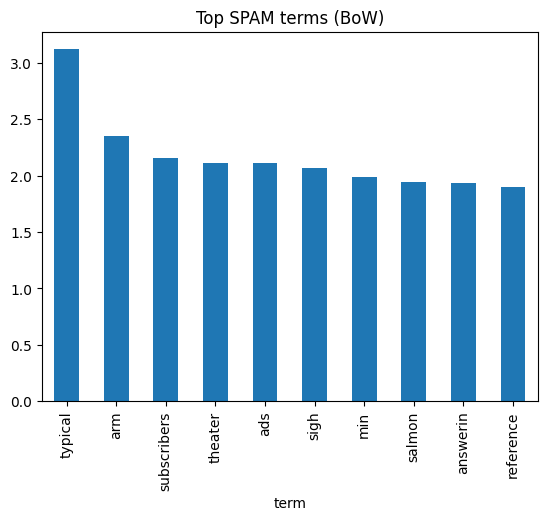

<Figure size 1000x400 with 0 Axes>

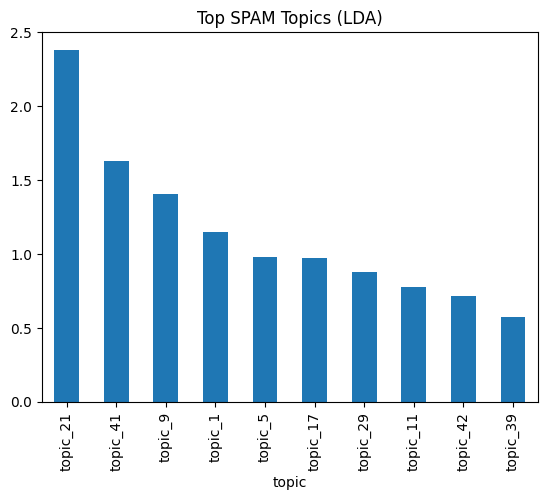

In [16]:
import matplotlib.pyplot as plt

# BoW
plt.figure(figsize=(10, 4))
bow_df.head(10).plot.bar(x="term", y="weight", legend=False, title="Top SPAM terms (BoW)")
plt.show()

# LDA topics
topic_df = pd.DataFrame({
    "topic": [f"topic_{i}" for i in range(len(topic_weights))],
    "weight": topic_weights
}).sort_values(by="weight", ascending=False)

plt.figure(figsize=(10, 4))
topic_df.head(10).plot.bar(x="topic", y="weight", legend=False, title="Top SPAM Topics (LDA)")
plt.show()
